## (Optional Exercise): Neural Networks for Regression ##

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Common imports
import numpy as np
import scipy.optimize as opt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# For data plots and visualization
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

#np.random.seed(1)
%load_ext autoreload
%autoreload 2

In [2]:
# Defining the training dataset
np.random.seed(0)
X = np.ones((1,70))*np.linspace(0,1,70)
y = np.sin(2*np.pi*X) + np.cos(4*np.pi*X) + np.random.randn(70)*0.2
X = X.T
y = y.T

# Partitioning the dataset into training and validation partitions
X_train, X_val, y_train,y_val = train_test_split(X,y,test_size=0.3)

# Hyperparameter settings
m = len(X)
alpha = 1
Lambda = 0.001

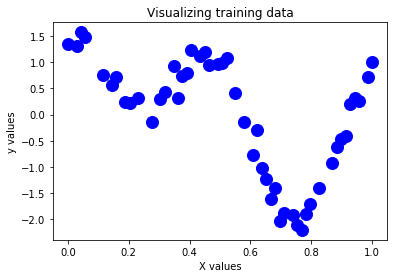

In [3]:
def plotData(X,y):
    plt.plot(X,y,'bo', markersize=12)
    plt.xlabel('X values')
    plt.ylabel('y values')
    plt.title('Visualizing training data');
    plt.show()
plotData(X_train,y_train)

In [4]:
def layer_sizes(X,y):
    Input = X.shape[1]
    Hidden = 8
    Output = y.shape[1]
    return Input,Hidden, Output
Input,Hidden, Output = layer_sizes(X,y);

In [5]:
def randtheta(L_in,L_out):
    np.random.seed(0)
    rand_epsilon = np.sqrt(6) / np.sqrt(L_in+L_out)
    theta = (np.random.random((L_out, L_in + 1)) *(2*rand_epsilon)) - rand_epsilon
    return theta
theta_init = np.concatenate((randtheta(Input,Hidden).reshape(((Input+1)*Hidden)),randtheta(Hidden,Output).reshape(((Hidden+1)*Output))))

In [6]:
def predict(theta,X):
    # Unroll the theta values as before
    theta1 = theta[:(Input+1)*Hidden].reshape((Hidden,(Input+1)))
    theta2 = theta[(Input+1)*Hidden:].reshape((Output,(Hidden+1)))
    m = np.float(len(X))

    # Forward propagation (also as before!)
    a1 = np.insert(X,0,1,axis=1)
    z2 = a1.dot(theta1.T)
    a2 = np.insert(np.tanh(z2),0,1,axis=1) 
    z3 = a2.dot(theta2.T)

    return z3

In [7]:
def nnModel(theta,X,y,Lambda):
    # Unroll the theta values from a 1D array
    theta1 = theta[:(Input+1)*Hidden].reshape((Hidden,(Input+1)))
    theta2 = theta[(Input+1)*Hidden:].reshape((Output,(Hidden+1)))
  
    # Forward propagation
    a1 = np.insert(X,0,1,axis=1)
    z2 = a1.dot(theta1.T)
    a2 = np.insert(np.tanh(z2),0,1,axis=1)
    z3 = a2.dot(theta2.T)

    # Cost function
    error = z3-y;
    error_sqrd = np.square(error);
    sum_error_sqrd = np.sum(error_sqrd); 
    cost =(1/(2*m)) * sum_error_sqrd;
    
    # Backpropagation
    d3 = (z3 - y)
    u  = np.tanh(z2)
    d2 = (z3 - y).dot(theta2[:,1:]) * (1 - np.power(u,2))
    D1 = d2.T.dot(a1) / m
    D2 = d3.T.dot(a2) / m
    if Lambda!=0: # This regularizes the gradients if Lambda > 0
        D1[:,1:] += (Lambda/m * theta1[:,1:])
        D2[:,1:] += (Lambda/m * theta2[:,1:])

     # Roll grads D1 and D2 back into 1D array
    grads = np.concatenate((D1.reshape(((Input+1)*Hidden)),D2.reshape(((Hidden+1)*Output))))

    return cost, grads

In [8]:
def nnCostFunction(theta,X,y,Lambda):
    cost = nnModel(theta,X,y,Lambda)[0]
    return cost
 
def nnGradientFunction(theta,X,y,Lambda):
    grad = nnModel(theta,X,y,Lambda)[1]
    return grad

In [9]:
def trainNNModel(theta_init,X,y,Lambda):
    obj_func = lambda t: nnCostFunction(t,X,y,Lambda);
    result = opt.minimize(obj_func, x0=theta_init, method='BFGS')
    return result.x, result.fun

In [10]:
theta, error = trainNNModel(theta_init,X_train,y_train,Lambda);
print("The cost is %f" %(error))
print("Computed mean squared error(MSE) is %f" %(mean_squared_error(y_train, predict(theta,X_train))))

The cost is 0.008048
Computed mean squared error(MSE) is 0.022994


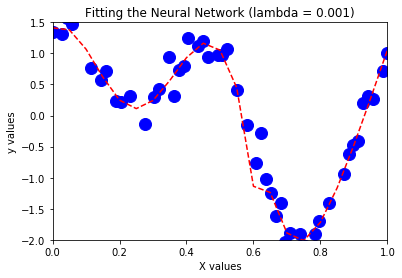

In [11]:
x_min, x_max = X_train[:,0].min() - 15, X_train[:,0].max() + 25
x = np.arange(x_min - 15, x_max + 25, 0.05).reshape(-1,1);
y_pred =predict(theta,x)
plt.plot(X_train,y_train,'bo', linewidth=2, markersize=12)
plt.plot(x,y_pred, 'r--')
plt.xlabel('X values')
plt.ylabel('y values')
plt.title('Fitting the Neural Network (lambda = %.3f)' % (Lambda));
plt.axis ([0, 1, -2, 1.5]);
plt.show()

In [12]:
def plot_learning_curves(init_theta,X_train, y_train,X_val,y_val,Lambda):
    m = X_train.shape[0]
    # You need to return these values correctly
    error_train = np.zeros((m, 1));
    error_val   = np.zeros((m, 1));
    
    for i, j in enumerate(range(1,m+1)):
        param, error    = trainNNModel(init_theta,X_train[0:m,:],y_train[0:m,:],Lambda)
        error_train[i] = nnCostFunction(param,X_train[0:j,:],y_train[0:j,:],0)
        error_val[i]   = nnCostFunction(param,X_val, y_val, 0);
    return error_train, error_val

In [13]:
error_train, error_val = plot_learning_curves(theta_init,X_train,y_train,X_val,y_val,Lambda);

In [14]:
print('# Training Examples\tTrain Error\tCross Validation Error\n');
for i in range(0,len(error_train)):
    print('  \t%d\t\t%f\t%f\n' % (i+1, error_train[i], error_val[i]));

# Training Examples	Train Error	Cross Validation Error

  	1		0.000002	0.008799

  	2		0.000009	0.008799

  	3		0.000016	0.008799

  	4		0.000684	0.008799

  	5		0.000724	0.008799

  	6		0.001574	0.008799

  	7		0.001584	0.008799

  	8		0.001634	0.008799

  	9		0.002164	0.008799

  	10		0.002177	0.008799

  	11		0.002192	0.008799

  	12		0.002289	0.008799

  	13		0.002408	0.008799

  	14		0.002454	0.008799

  	15		0.002456	0.008799

  	16		0.002704	0.008799

  	17		0.002736	0.008799

  	18		0.002745	0.008799

  	19		0.002758	0.008799

  	20		0.002765	0.008799

  	21		0.002781	0.008799

  	22		0.002993	0.008799

  	23		0.003467	0.008799

  	24		0.003534	0.008799

  	25		0.003635	0.008799

  	26		0.003749	0.008799

  	27		0.003755	0.008799

  	28		0.003964	0.008799

  	29		0.004500	0.008799

  	30		0.005578	0.008799

  	31		0.005579	0.008799

  	32		0.005627	0.008799

  	33		0.005627	0.008799

  	34		0.005734	0.008799

  	35		0.005734	0.008799

  	36		0.005810	0.008799

  	37		0.006372	0


 Plotting the Learning curves for Linear Regression ... 



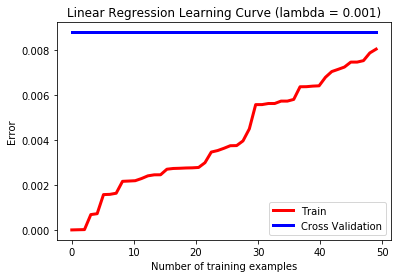

In [15]:
print('\n Plotting the Learning curves for Linear Regression ... \n')

xvals = np.linspace(0, len(error_train), len(error_train)) 
plt.plot(xvals,error_train, 'r-',linewidth = 3,label='Train')
plt.plot(xvals,error_val,'b-',linewidth = 3,label='Cross Validation')
plt.xlabel('Number of training examples')
plt.ylabel('Error')
plt.title('Linear Regression Learning Curve (lambda = %.3f)' % Lambda);
plt.legend()
plt.show()